In [1]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields
from results_analysis_tools.plugins.histogram_processor import DatasetHistogramProcessor
from results_analysis_tools.plugins.temporal_evolution_processor import TemporalEvolutionProcessor
from results_analysis_tools.plugins.synchrony_experiments_processor import SynchronyExperimentsProcessor
from results_analysis_tools.plugins.evaluation_results_processor import EvaluationResultsProcessor
from results_analysis_tools.plugins.wandb_summary_processor import WandbSummaryProcessor


In [2]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/results.pkl",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
result_analyzer = ResultAnalyzer(analysis_paths)
all_results = result_analyzer.get_all_results



# Model Evaluation

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


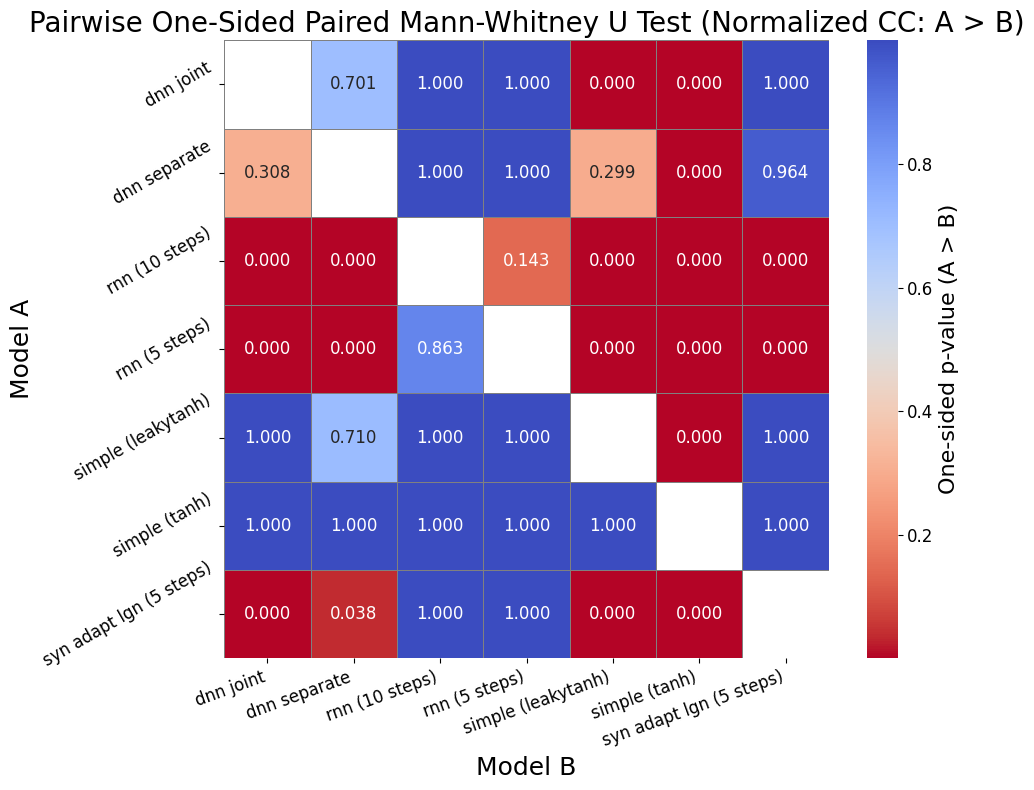

In [3]:
filename = f"model_types_p_value_heatmap_cc_norm.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.MODEL_TYPES_P_VALUES_HEATMAP)
ResultsPlotter.plot(plot_data, PlottingVariants.MODEL_TYPES_P_VALUES_HEATMAP, save_fig=f"{PLOTING_DESTINATION}{filename}")

In [4]:
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.MODEL_TYPES_CORRELATION_COMPARISON)
df_melted = plot_data
df_melted

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


,model_variant,Correlation Type,Correlation Value
0,simple (tanh),Pearson CC,0.190005
1,simple (tanh),Pearson CC,0.227332
2,simple (tanh),Pearson CC,0.233091
3,simple (tanh),Pearson CC,0.170677
4,simple (tanh),Pearson CC,0.238178
...,...,...,...
275,syn adapt lgn (5 steps),Normalized CC,0.898149
276,syn adapt lgn (5 steps),Normalized CC,0.901183
277,syn adapt lgn (5 steps),Normalized CC,0.891461
278,syn adapt lgn (5 steps),Normalized CC,0.893890


In [5]:
wandb_processor = WandbSummaryProcessor(all_results)
df = EvaluationResultsProcessor.get_wandb_evaluation_results(wandb_processor.get_results)
df.columns

Index(['experiment_variant', 'model_variant', 'CC_ABS', 'CC_NORM', 'epochs',
       'learning_rate', 'subset_variant', 'neuron_model_layer_size',
       'neuron_model_num_layers', 'neuron_model_is_residual',
       'synaptic_adaptation', 'synaptic_adaptation_size',
       'synaptic_adaptation_num_layers', 'num_backpropagation_time_steps'],
      dtype='object')

## Model Setup

In [6]:
result_analyzer.get_latex_evaluation_setup()

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


'\\begin{table}\n\\caption{Setup of the models in evaluation:}\n\\label{tab:model_configs}\n\\begin{tabular}{lrrrrrrrr}\n\\toprule\nModel Variant & Epochs & lr & n-ls & n-nl & n-res & s-ls & s-nl & n-tbptt \\\\\n\\midrule\nsimple (tanh) & 10 & 0.000008 & 10 & 5 & False & 10 & 1 & 1 \\\\\nsimple (leakytanh) & 10 & 0.000075 & 10 & 5 & False & 10 & 1 & 1 \\\\\ndnn joint & 10 & 0.000010 & 10 & 5 & True & 10 & 1 & 1 \\\\\ndnn separate & 10 & 0.000010 & 10 & 5 & True & 10 & 1 & 1 \\\\\nrnn (5 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 1 & 5 \\\\\nrnn (10 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 1 & 10 \\\\\nsyn adapt lgn (5 steps) & 40 & 0.000030 & 10 & 3 & True & 10 & 2 & 5 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

## Overall Model Variant Comparison

In [7]:
result_analyzer.get_evaluation_results_summary(return_latex=False)

/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(
/home/david/source/diplomka/results_analysis_tools/plugins/wandb_summary_processor.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["model_variant", "Correlation Type"])["Correlation Value"]


,model_variant,N-CC (mean),P-CC (mean),N-CC (std),P-CC (std)
5,rnn (10 steps),0.9212,0.7500,0.0084,0.0082
4,rnn (5 steps),0.9176,0.7471,0.0103,0.0089
6,syn adapt lgn (5 steps),0.8935,0.7275,0.0043,0.0042
2,dnn joint,0.8803,0.7168,0.0021,0.0034
1,simple (leakytanh),0.8778,0.7147,0.0014,0.0032
3,dnn separate,0.8430,0.6864,0.0940,0.0766
0,simple (tanh),0.2767,0.2252,0.0400,0.0321
7,syn adapt lgn (10 steps),NaN,NaN,NaN,NaN


/home/david/source/diplomka/results_analysis_tools/plugins/evaluation_results_processor.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variant_string] = df[variant_string].map(


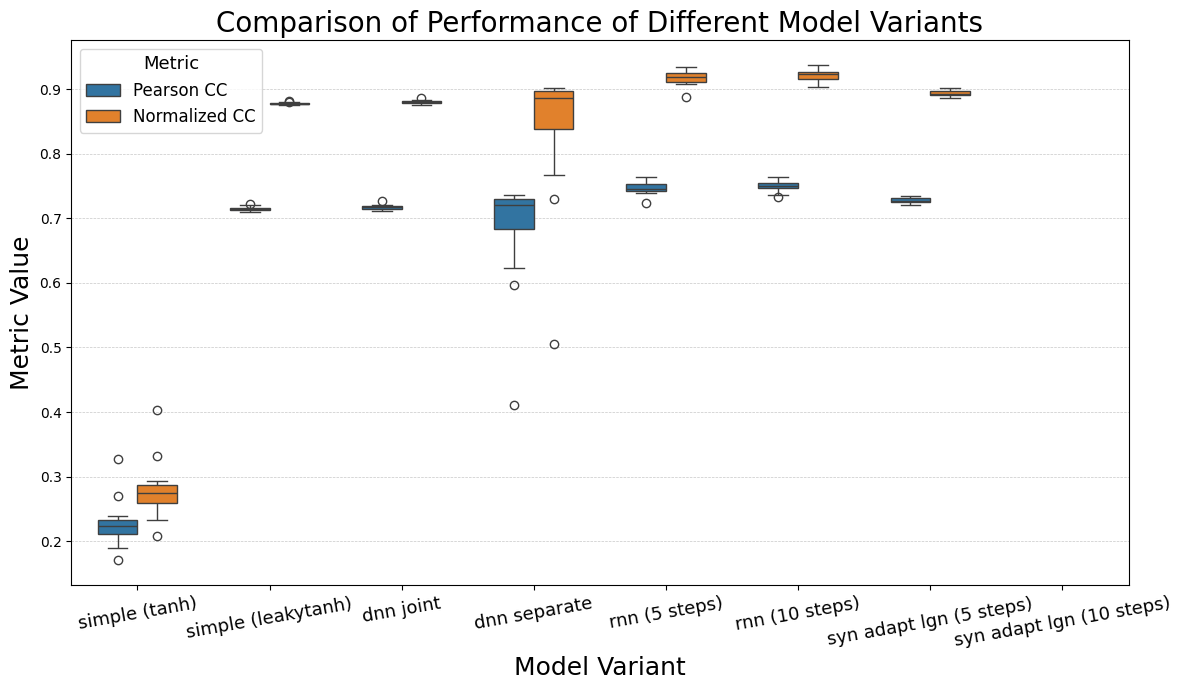

In [8]:
filename = f"model_types_correlation_comparison.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.MODEL_TYPES_CORRELATION_COMPARISON)
ResultsPlotter.plot(plot_data, PlottingVariants.MODEL_TYPES_CORRELATION_COMPARISON, save_fig=f"{PLOTING_DESTINATION}{filename}")

# Full Dataset Analysis

## Time Bin Spike Counts
This part of code shows how to plot the distribution of spike counts across all time bins and how to write the exact ratios.

In [9]:
result_analyzer.get_mean_spike_counts(False,).head(5)

,time_step,spike_count_bin,normalized_density
0,1,0,0.9944
1,1,1,0.0056
2,1,2,0.0000
3,1,3,0.0000
4,1,4,0.0000


In [10]:
result_analyzer.get_mean_spike_counts(True).head(5)

,time_step,spike_count_bin,normalized_density
0,1,0,0.9944
1,1,1,0.0056
2,1,2,0.0000
3,1,3,0.0000
4,1,4,0.0000


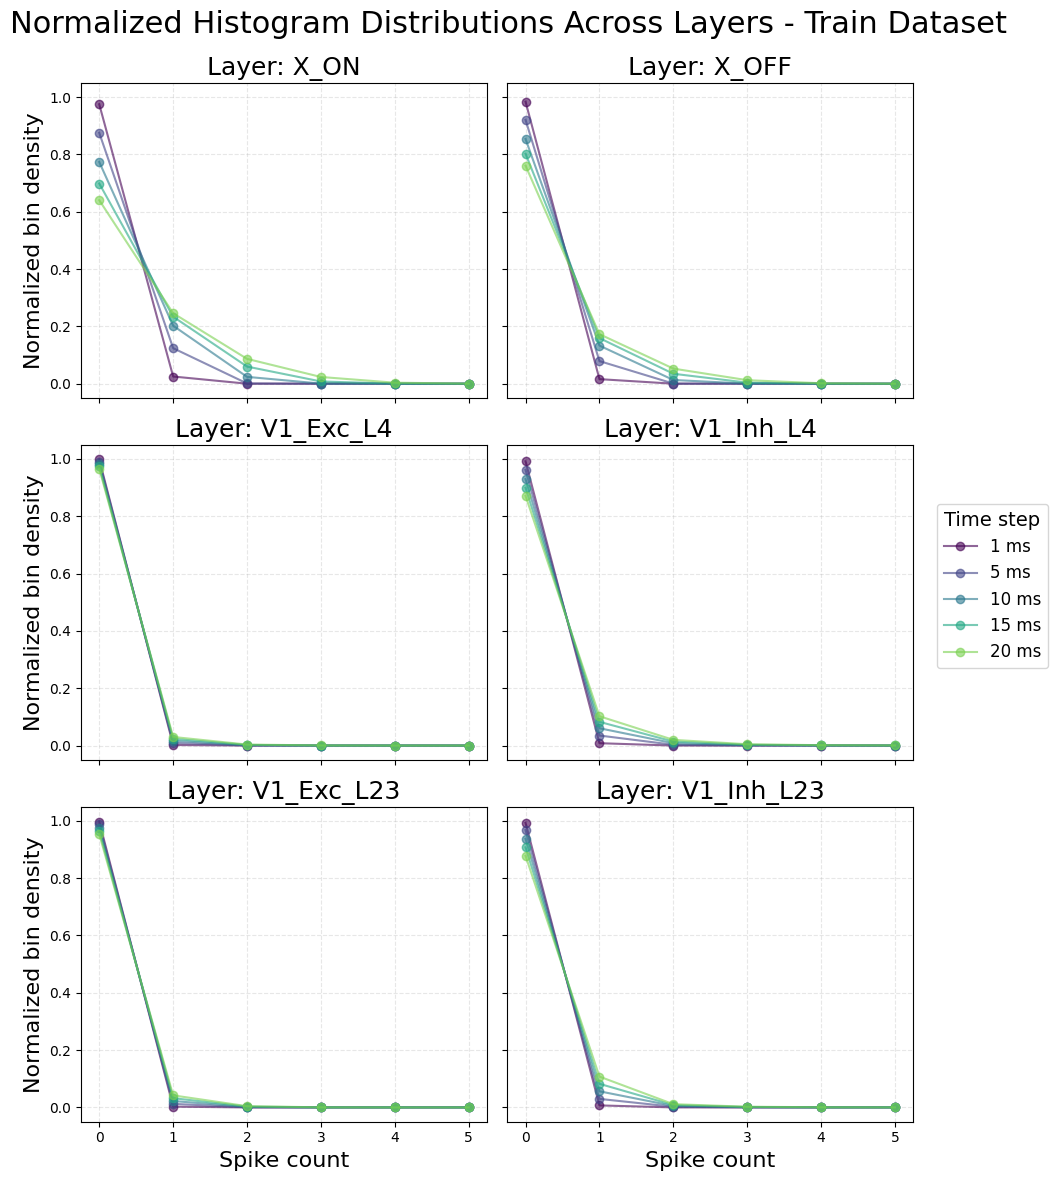

In [11]:
is_test = False
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

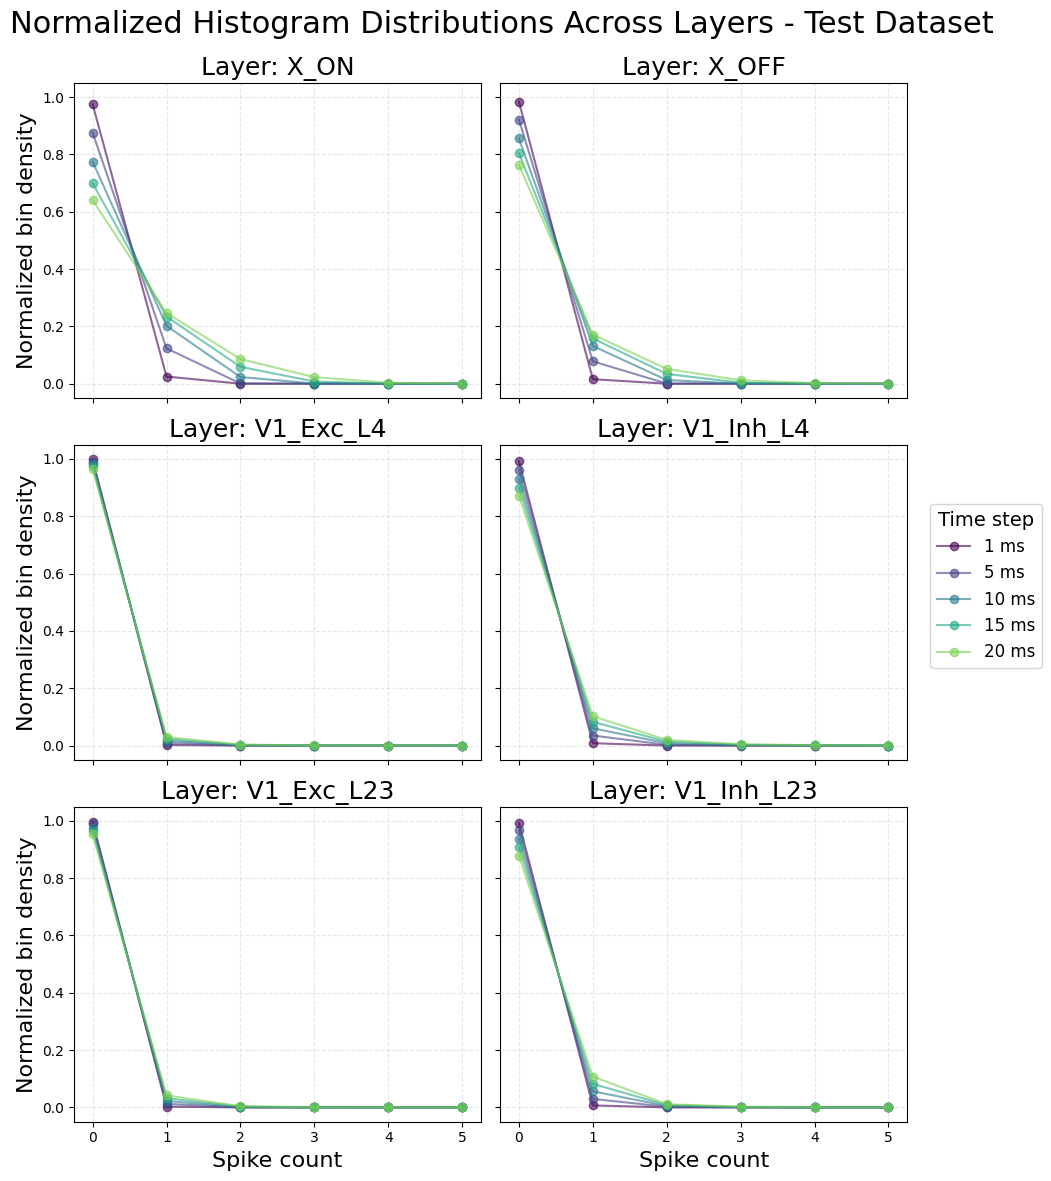

In [ ]:
is_test = True
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

## Temporal Distribution of Spikes

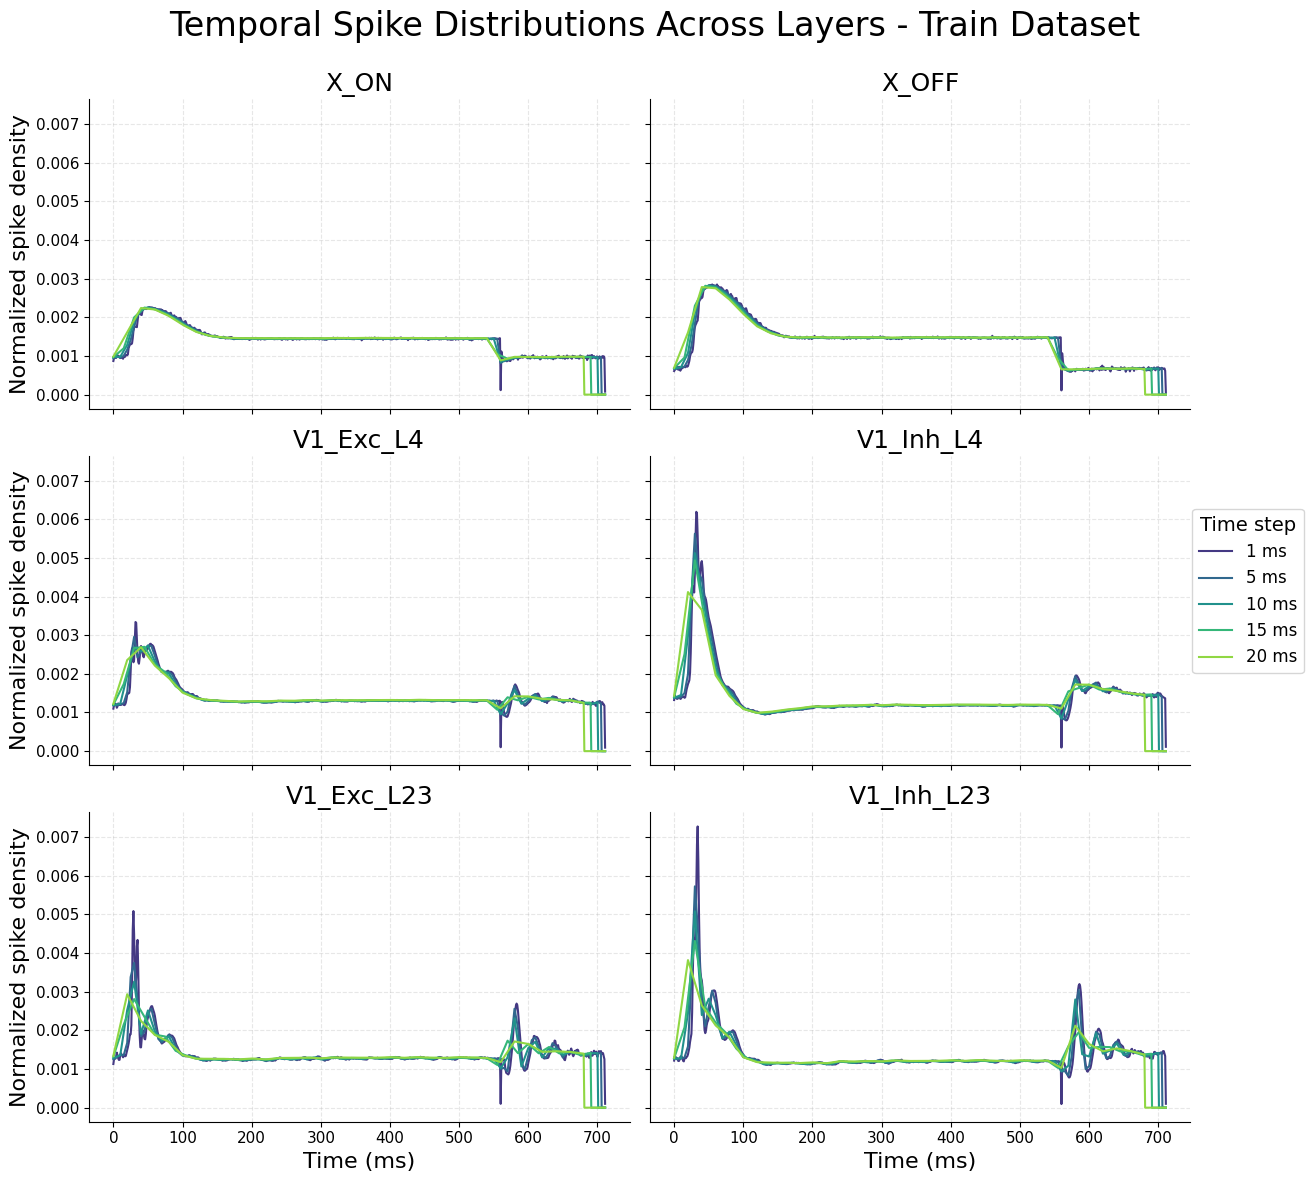

In [ ]:
is_test = False
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, is_test=is_test)

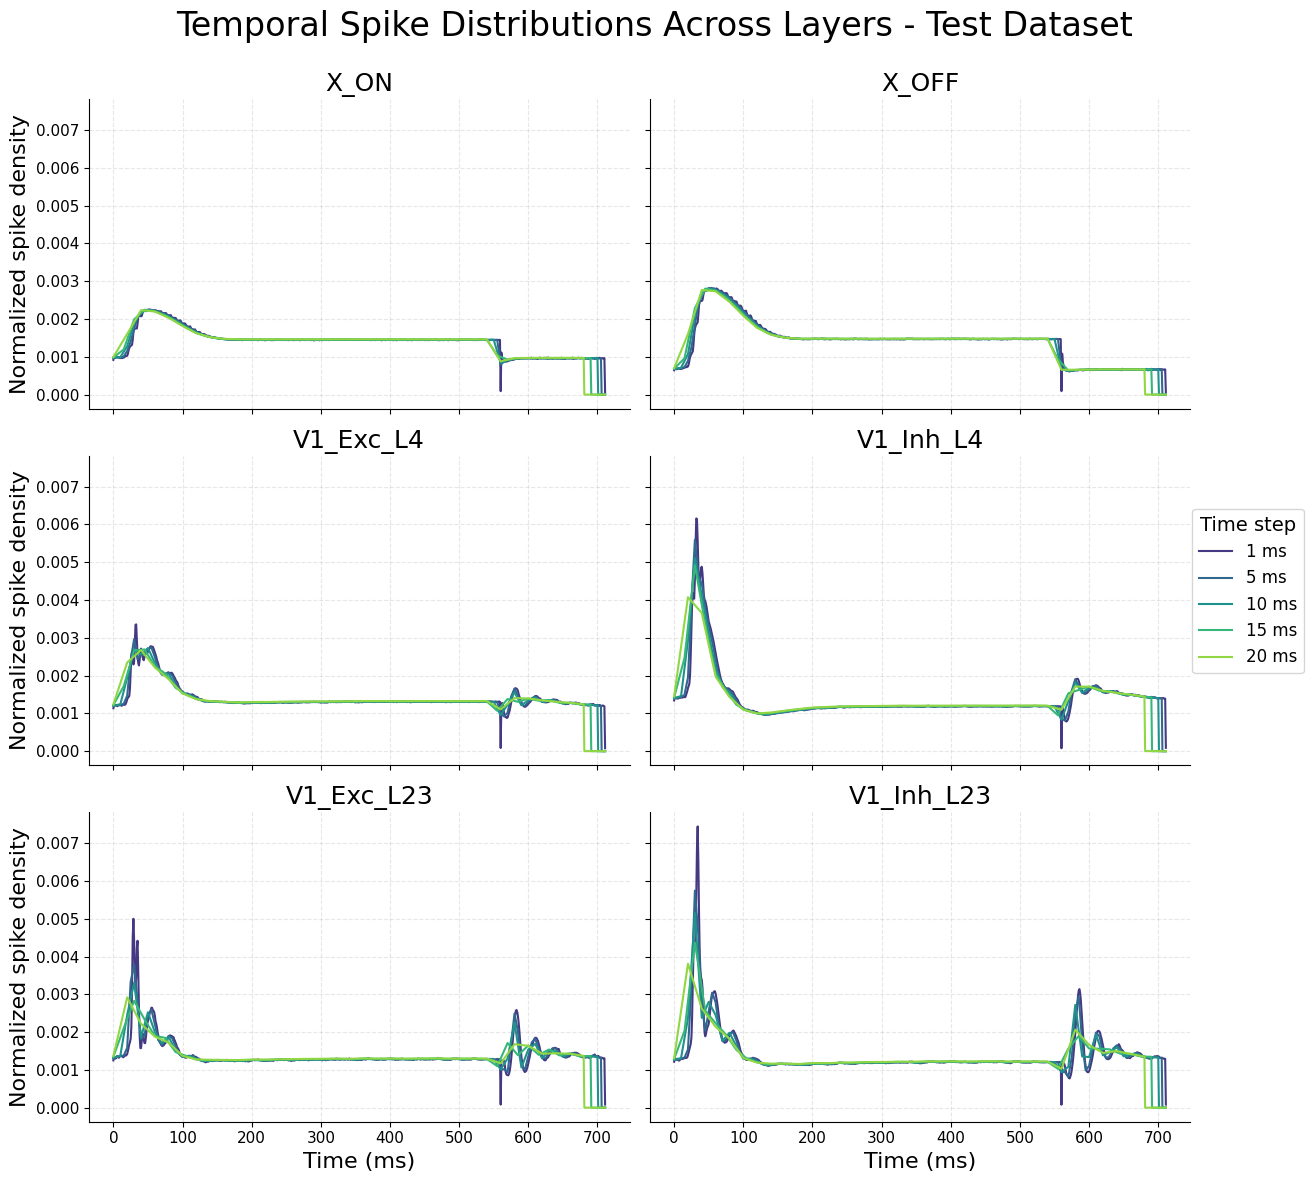

In [ ]:
is_test = True
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, is_test=is_test)

/home/david/source/diplomka/results_analysis_tools/plotting/temporal_spike_distribution.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


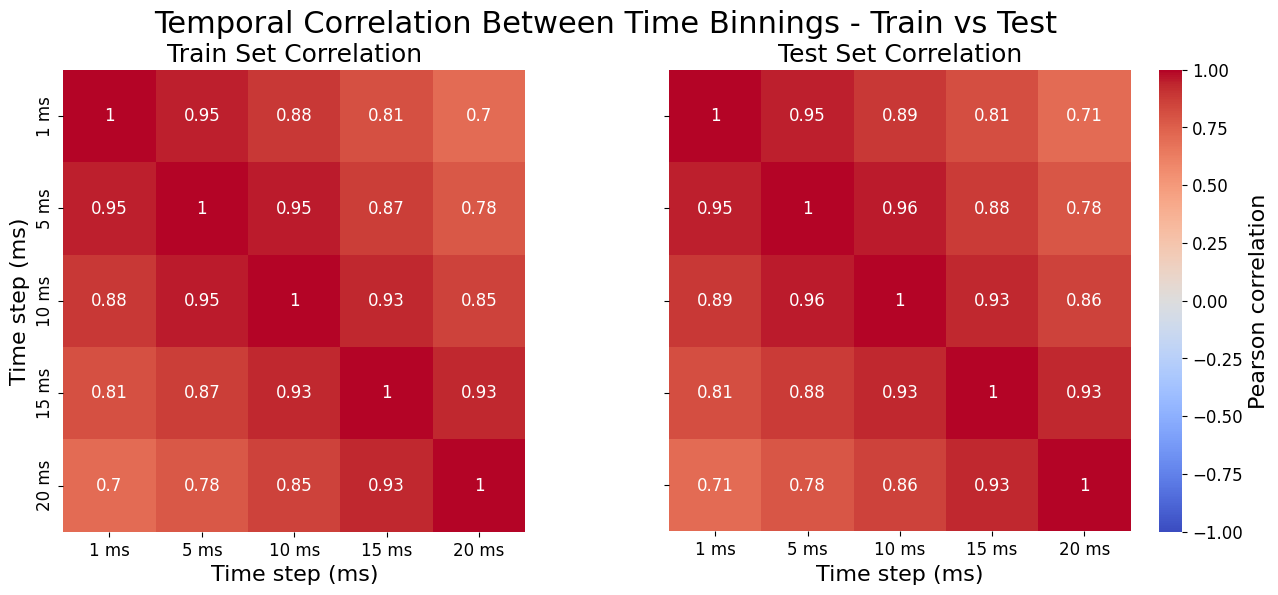

In [ ]:
filename = "temporal_correlation_time_bin_size.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
train_corr = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, is_test=False)
test_corr = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, is_test=True)
ResultsPlotter.plot((train_corr, test_corr), PlottingVariants.FULL_CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, save_fig=destination, is_test=is_test)

## Synchrony 

Plotting of the synchrony boxplot across different time bin sizes.

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


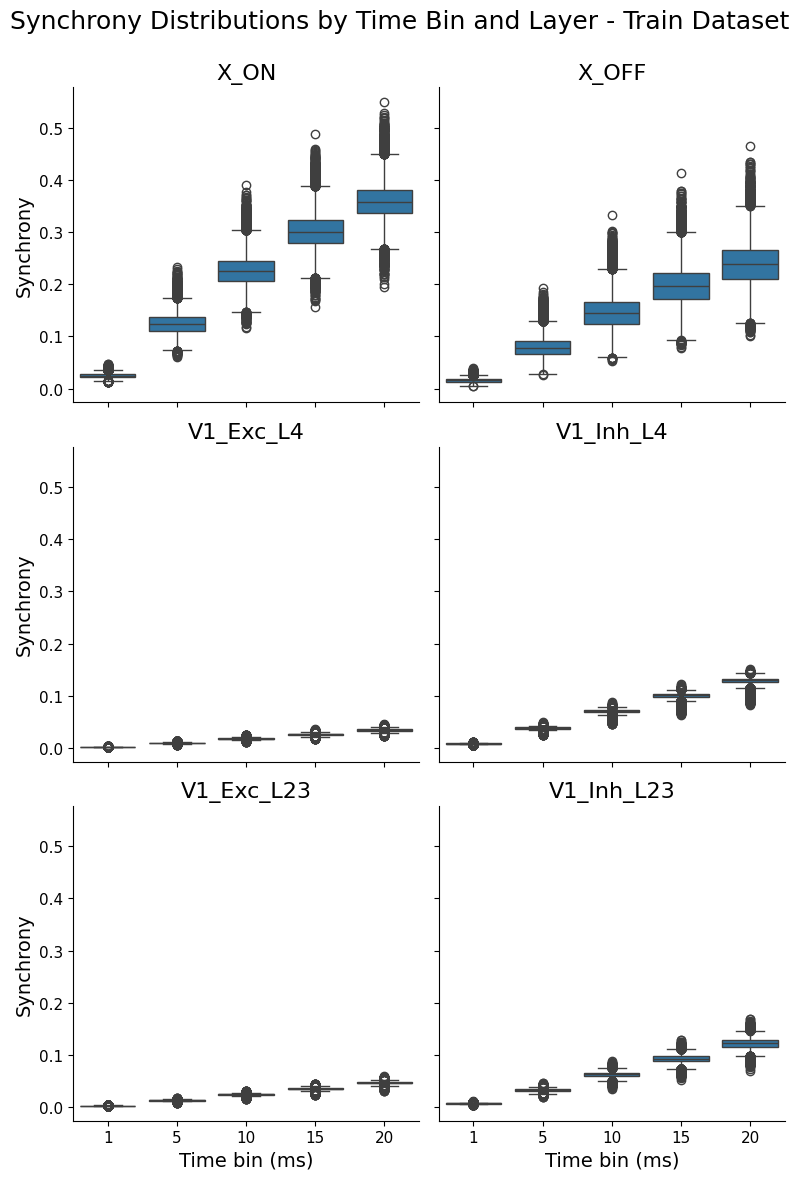

In [ ]:
is_test = False
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_SYNCHRONY_TIME_BINS, save_fig=destination, is_test=is_test)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


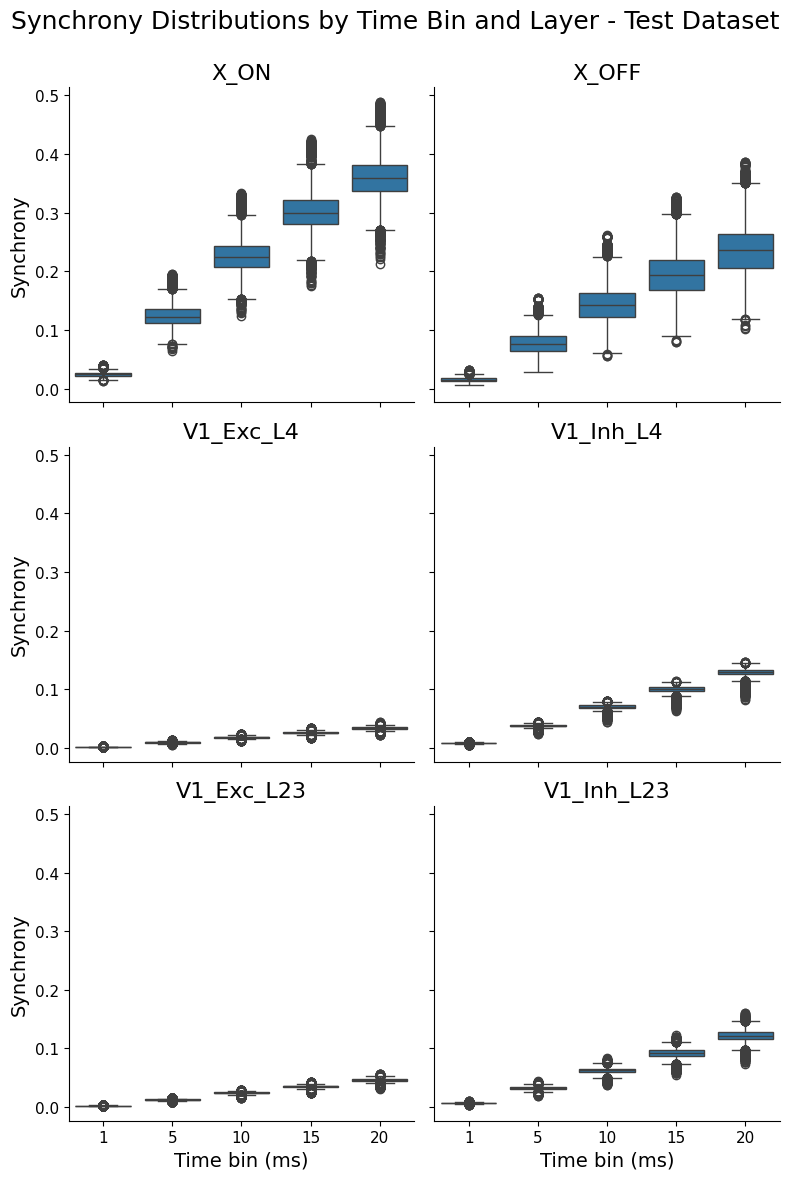

In [ ]:
is_test = True
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.FULL_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.FULL_SYNCHRONY_TIME_BINS, save_fig=destination, is_test=is_test)

In [ ]:
result_analyzer.get_synchrony_summary(is_test=False, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,time_step,mean,variance
0,1,0.0101,0.0001
1,5,0.0494,0.0018
2,10,0.0912,0.0057
3,15,0.1256,0.0098
4,20,0.1551,0.0134


In [ ]:
result_analyzer.get_synchrony_summary(is_test=True, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,time_step,mean,variance
0,1,0.0101,0.0001
1,5,0.0491,0.0017
2,10,0.0908,0.0057
3,15,0.1250,0.0097
4,20,0.1545,0.0133


# Subset Dataset Analysis


## Time Bin Spike Counts

In [ ]:
is_test=False
result_analyzer.get_mean_spike_counts(is_test, process_subset=True)

,spike_count_bin,full_density,subset_mean,subset_std
0,0,0.9105,0.9102,0.0004
1,1,0.0710,0.0712,0.0003
2,2,0.0147,0.0148,0.0001
3,3,0.0032,0.0032,0.0000
4,4,0.0005,0.0005,0.0000
5,5,0.0001,0.0001,0.0000


## Temporal behavior comparison of Subset and Full dataset

/home/david/source/diplomka/results_analysis_tools/plugins/temporal_evolution_processor.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_df.groupby(["layer", "subset_id"])
/home/david/source/diplomka/results_analysis_tools/plotting/temporal_spike_distribution.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g.axes.flatten(), combined_df.groupby("layer")


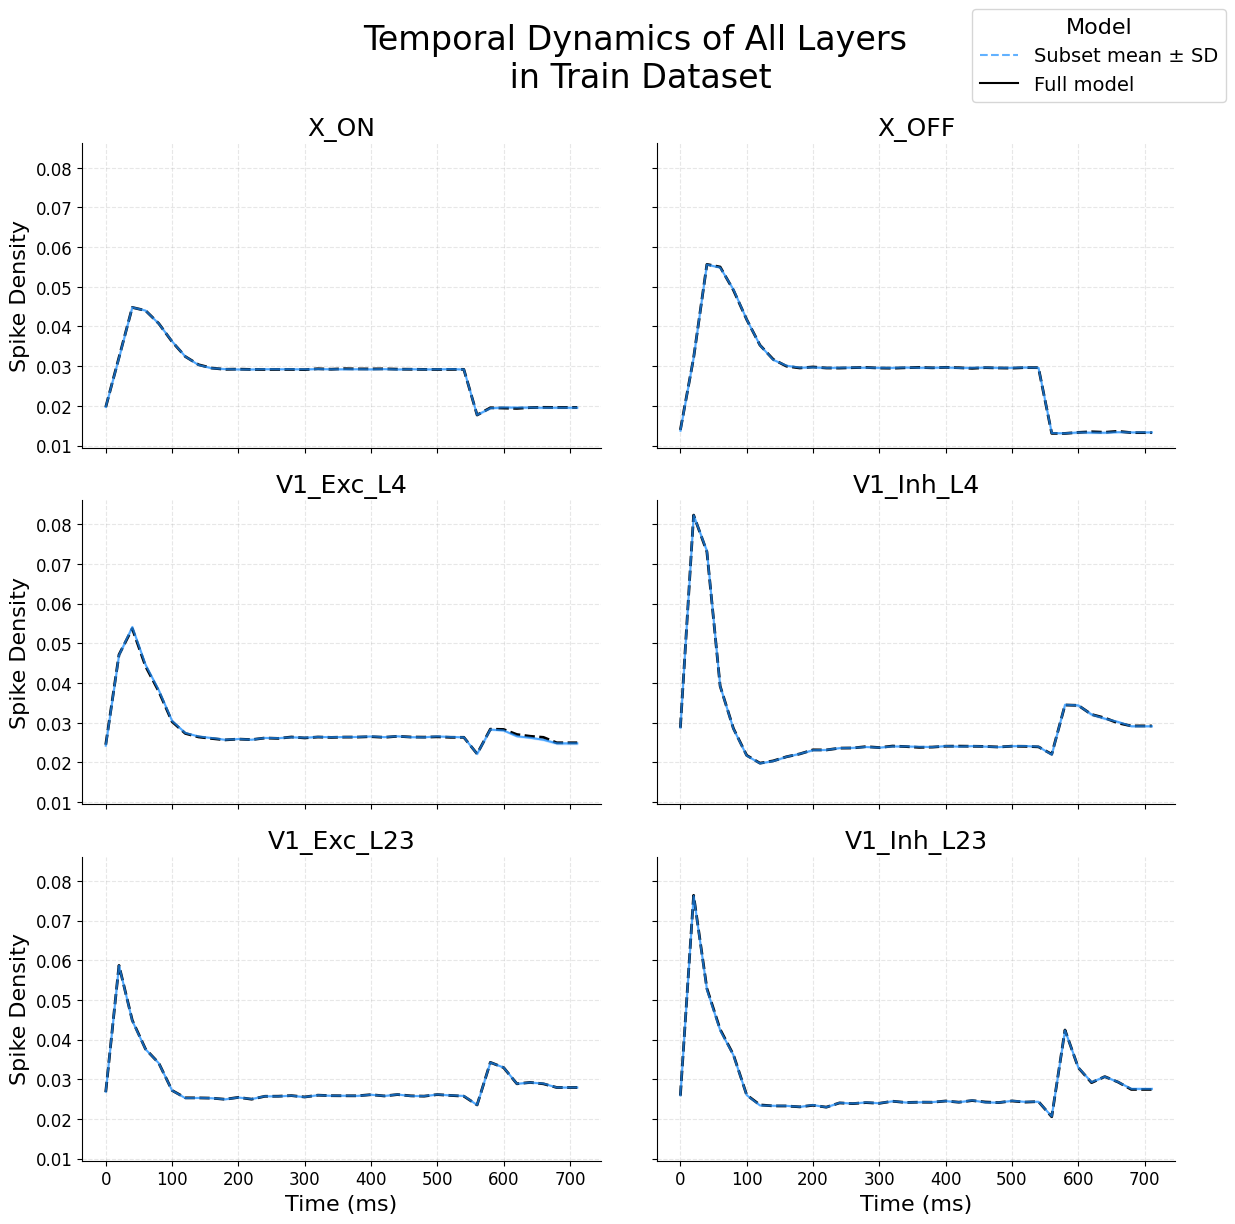

In [ ]:
is_test = False
filename = f"temporal_distribution_subset_vs_full_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SUBSET_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SUBSET_TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

## Synchrony Comparison

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')
Index(['subset_id', 'layer', 'statistics_type', 'values'], dtype='object')


/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_comparison.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strip_df = df.groupby(["layer", "model_type"]).sample(


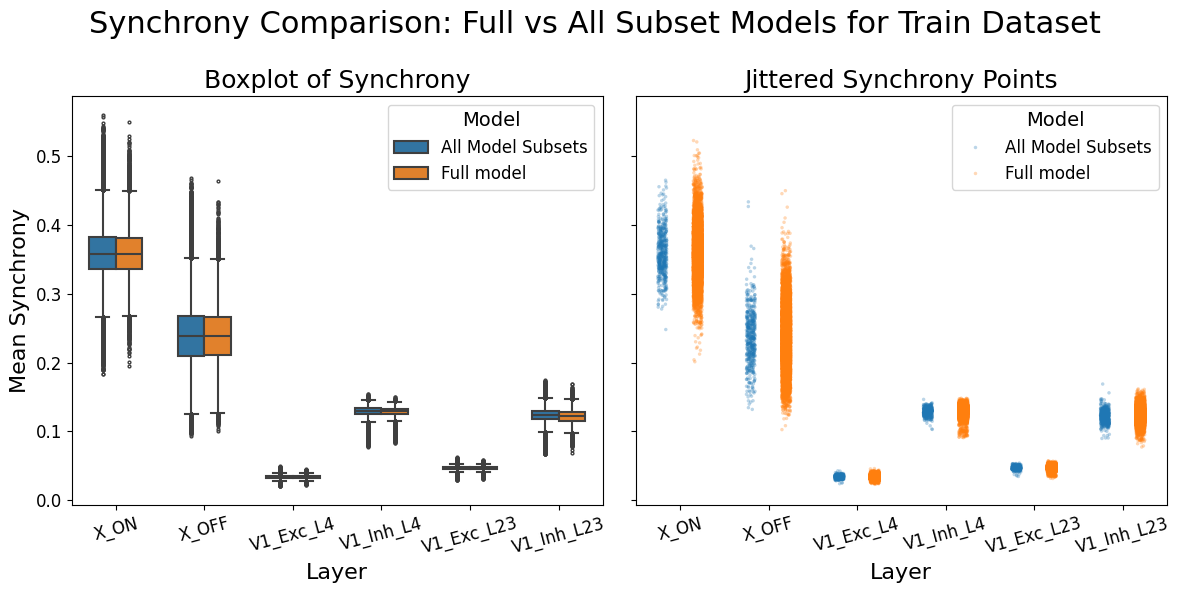

In [ ]:
is_test = False
filename = f"synchrony_comparison_subset_full_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SUBSET_SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SUBSET_SYNCHRONY_TIME_BINS, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")